In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

Using numpy backend.


In [2]:
%matplotlib inline

## Load previously compiled data

The raw (ping-by-ping) data were averaged to get mean volume backscattering strengh (MVBS) and then cleaned up by PCP. This is the same set of data I used to run the Matlab PALM-NMF.

Note that **all echograms in this notebook are plotted upside-down**, so the DVM you see you opposite of what actually happens. In reality the animals move toward the surface during the night and move downward during the day.

In [3]:
# Load PCP-cleaned MVBS data
MVBS_path = '/home/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [4]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()

The data is organized with dimension [frequency x number of days x depth x time of day].

In [5]:
L_sep.shape

(3, 62, 37, 144)

The 3 frequencies of data look like:

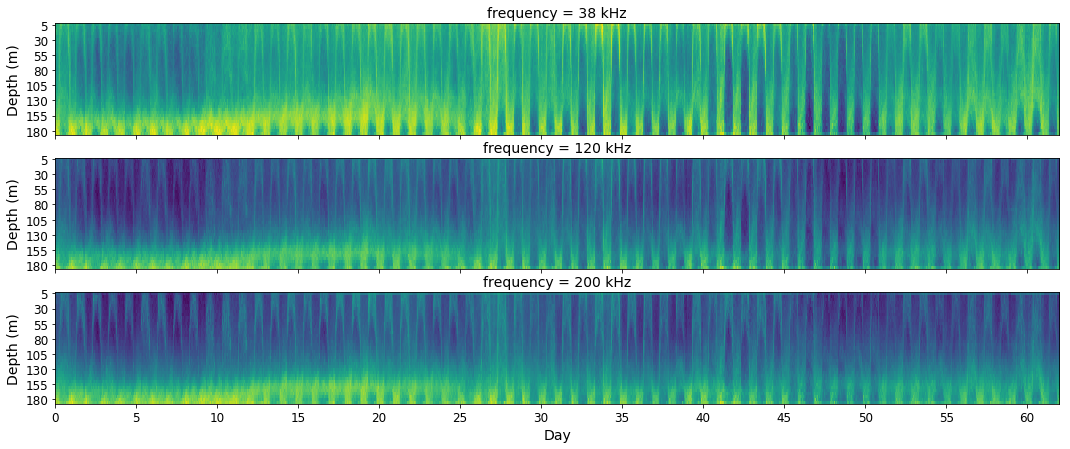

In [6]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,65*144,144*5))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

Here the y-axis starts at 5 m because I've cut off the top 5 m of data which include a lot of super strong surface reflection that can throw out the decomposition.

The data within each day look like:

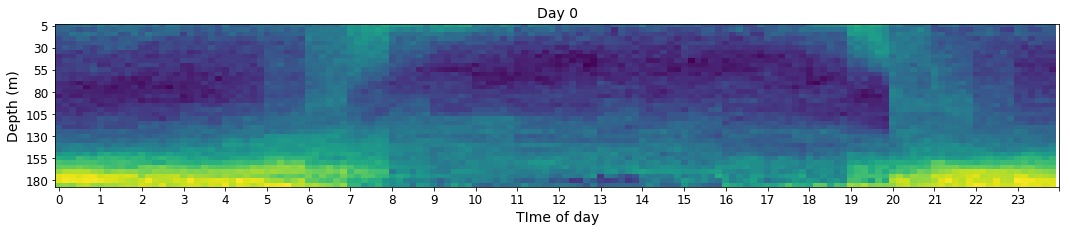

In [7]:
fig = plt.figure(figsize=(18,3))
plt.imshow(L_sep[0,0,:,:].squeeze(),aspect='auto')
plt.xticks(range(0,150,6), range(24), fontsize=12)
plt.yticks(np.arange(0,37,5), (np.arange(0,37,5)+1)*depth_bin_size, fontsize=12)
plt.xlabel('TIme of day', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('Day 0',fontsize=14)
plt.show()

Note how each hour is a vertical "stripe." This is because the data were collected from only the first 20 mins of each hour, so there is a discontinuity in the raw data itself.

### Try decimating data

In [8]:
# Average across time of day columns
tod_num = 6
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [9]:
L_sep_reduce.shape

(3, 62, 37, 24)

On the grand scale the decimated data look very similar to without averaging over the pings:

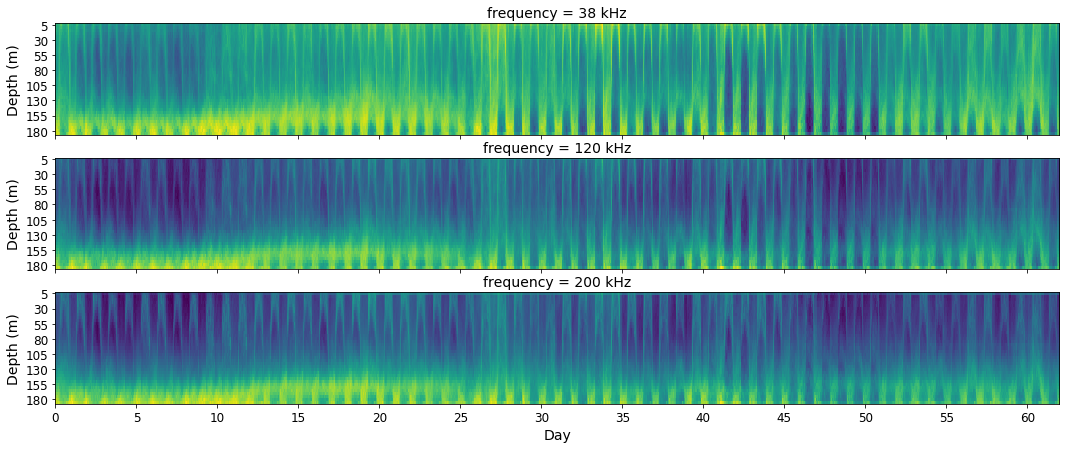

In [10]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(65*144/tod_num),int(144/tod_num*5)))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

But obviously the effects are more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

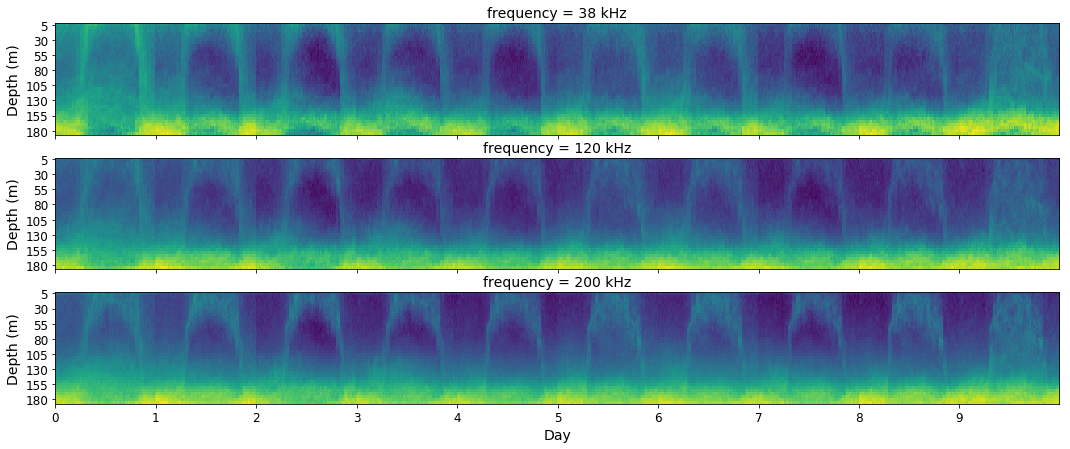

In [11]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,10*144,144))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

And then we compare it with the decimated data:

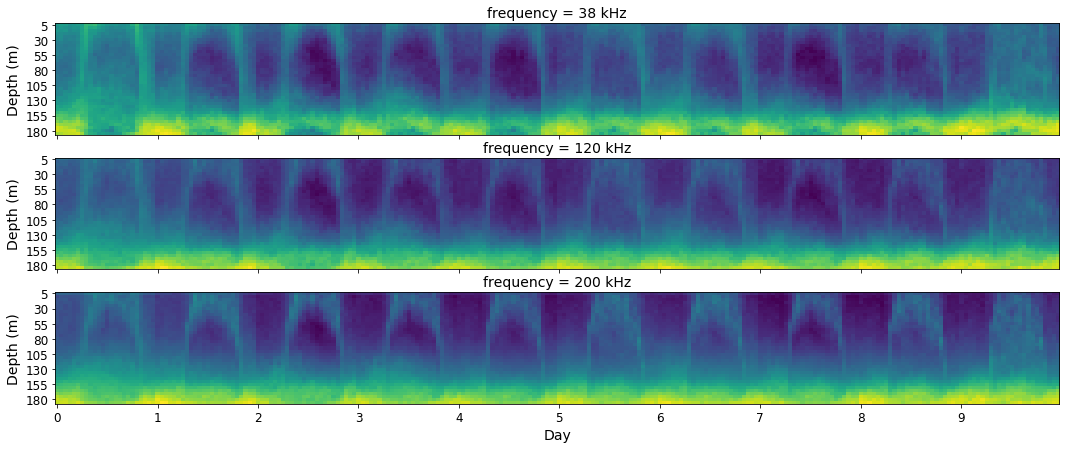

In [12]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(10*144/tod_num),int(144/tod_num*1)))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Try parafac decomposition

Before in 2018-10-29 notebook was trying to do parafac decomposition of data from 1 frequency. Now try to see if can run 4D decomposition with frequency being one of the dimensions.

In [13]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

In [14]:
# sonar_tensor = tl.tensor(L_sep)
sonar_tensor = tl.tensor(L_sep_reduce)

In [15]:
sonar_tensor.shape

(3, 62, 37, 24)

### Rank=3

In [16]:
kruskal_rank = 3
factors_kruskal_3 = parafac(sonar_tensor, rank = kruskal_rank)
factors_kruskal_nonneg_3 = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [17]:
[factors_kruskal_3[f].shape for f in range(len(factors_kruskal_3))]

[(3, 3), (62, 3), (37, 3), (24, 3)]

In [18]:
full_tensor_3 = tl.kruskal_to_tensor(factors_kruskal_3)
full_tensor_nonneg_3 = tl.kruskal_to_tensor(factors_kruskal_nonneg_3)

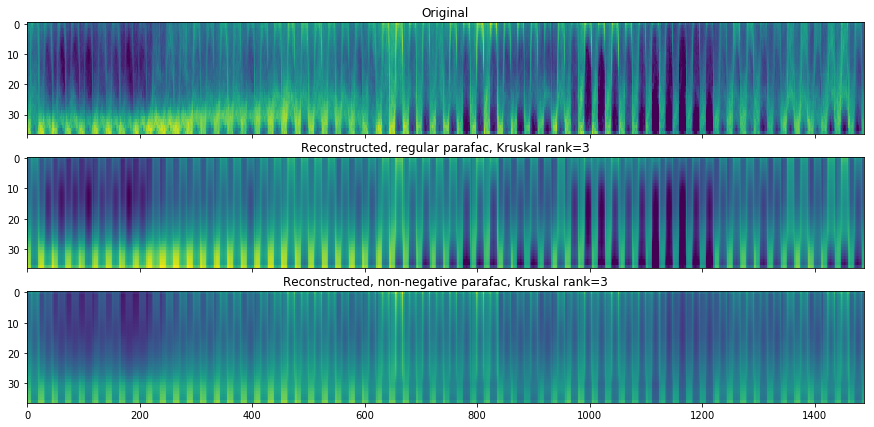

In [19]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

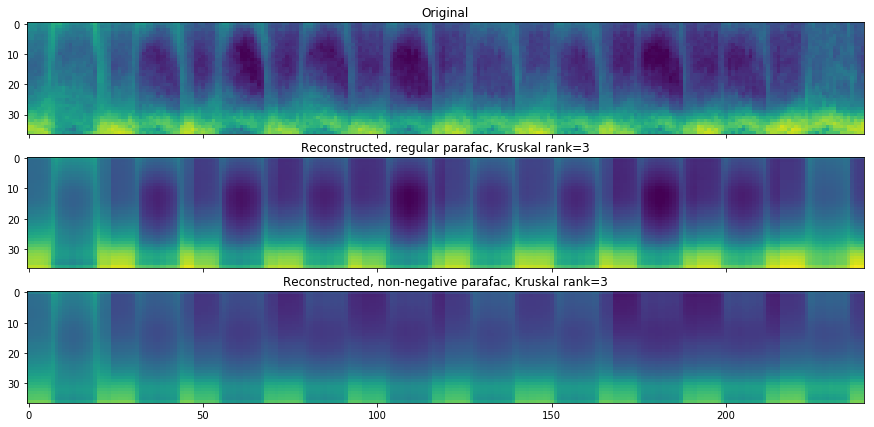

In [20]:
fig,ax = plt.subplots(3,1,figsize=(15,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[0].set_title('Original')
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_3[0,:10,:,:]).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[1].set_title('Reconstructed, regular parafac, Kruskal rank=%d'%kruskal_rank)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:10,:,:]+sonar_tensor.min()).squeeze(), mode=1),
             aspect='auto',vmax=-57, vmin=-85)
ax[2].set_title('Reconstructed, non-negative parafac, Kruskal rank=%d'%kruskal_rank)
plt.show()

## Checking regular parafac results

In [32]:
sonar_tensor.shape

(3, 62, 37, 24)

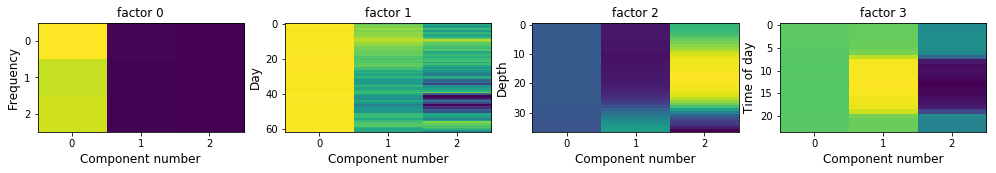

In [33]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

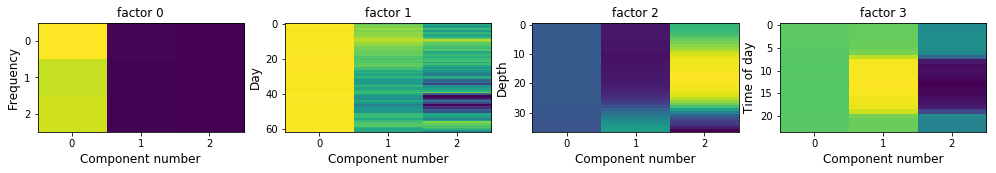

In [34]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

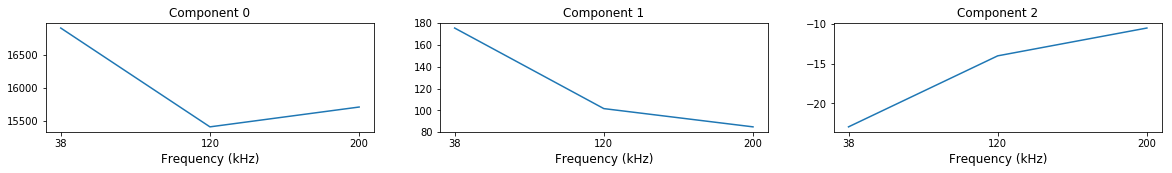

In [59]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_3[0][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200])
    ax[i].set_xlabel('Frequency (kHz)', fontsize=12)
plt.show()

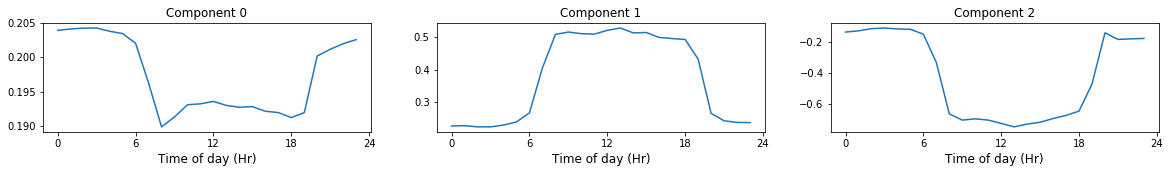

In [60]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_3[3][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_xticklabels(np.arange(0,25,6))
    ax[i].set_xlabel('Time of day (Hr)', fontsize=12)
plt.show()

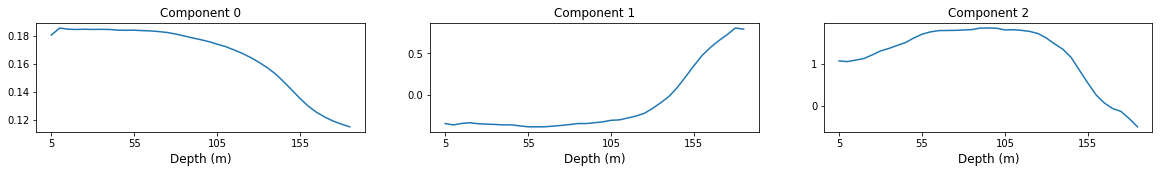

In [61]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_3[2][:,i],label=i)
    ax[i].set_xticks(np.arange(0,37,10))
    ax[i].set_xticklabels((np.arange(0,37,10)+1)*depth_bin_size)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Depth (m)',fontsize=12)
plt.show()

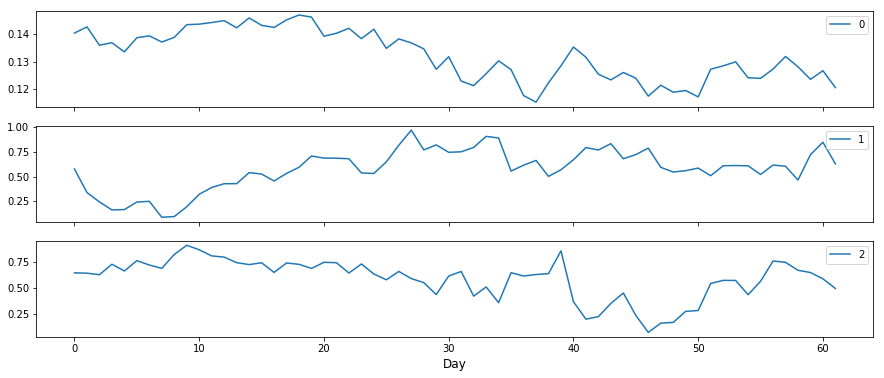

In [62]:
fig,ax = plt.subplots(3,1,figsize=(15,6),sharex=True)
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[1][:,i],label=i)
    ax[i].legend(loc='upper right')
ax[i].set_xlabel('Day',fontsize=12)
plt.show()

### Combine pairs of factors

In [63]:
import itertools

In [64]:
# Khatri-kao product to combine the factors
kr_patterns = []
kr_combs = []
for x,y in itertools.combinations(range(4),2):
    kr_patterns.append((x,y))
    kr_combs.append(khatri_rao((factors_kruskal_3[x],factors_kruskal_3[y])))

In [65]:
kr_patterns

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [66]:
[x.shape for x in kr_combs]

[(186, 3), (111, 3), (72, 3), (2294, 3), (1488, 3), (888, 3)]

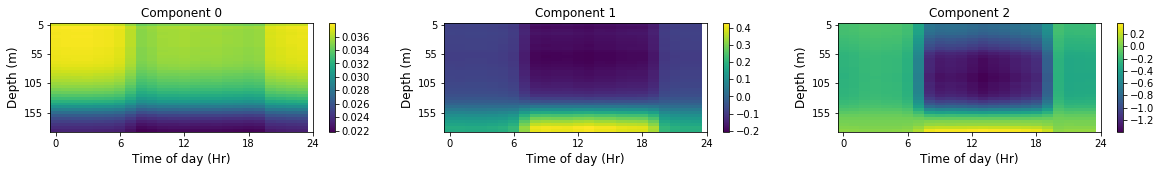

In [67]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[-1][:,fac].reshape(37,24),aspect='auto')
    plt.xticks(np.arange(0,25,6), np.arange(0,25,6))
    plt.xlabel('Time of day (Hr)', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

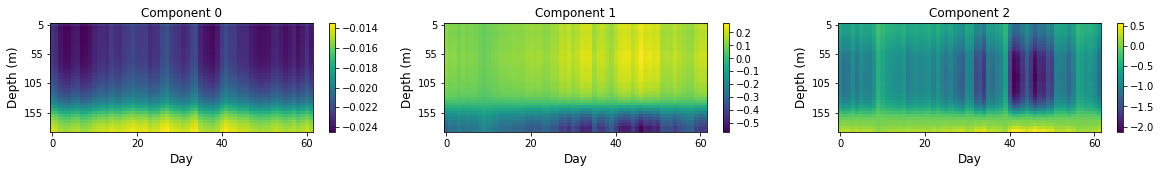

In [68]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kr_combs[3][:,fac].reshape(62,37).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

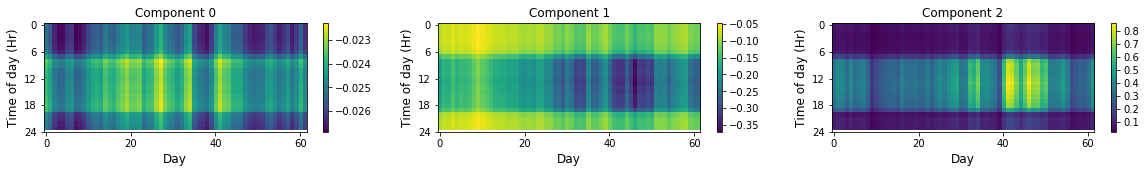

In [69]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kr_combs[-2][:,fac].reshape(62,24).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.yticks(np.arange(0,25,6), np.arange(0,25,6))
    plt.ylabel('Time of day (Hr)', fontsize=12)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.colorbar()

In [70]:
[x.shape for x in kr_combs]

[(186, 3), (111, 3), (72, 3), (2294, 3), (1488, 3), (888, 3)]

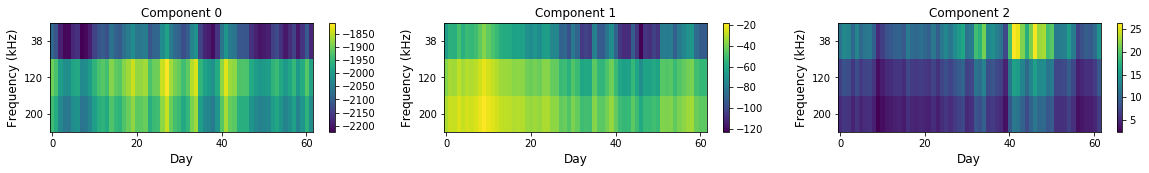

In [71]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[0][:,fac].reshape(3,62),aspect='auto')
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

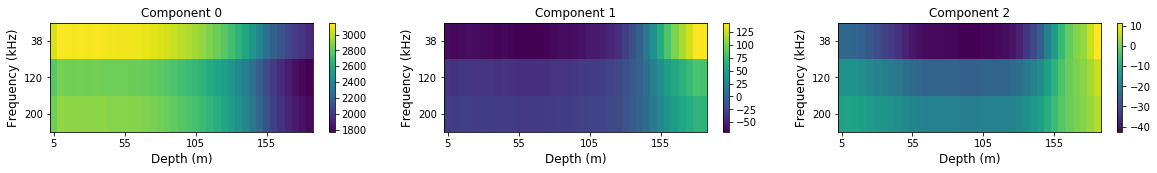

In [72]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[1][:,fac].reshape(3,37),aspect='auto')
    plt.xticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.xlabel('Depth (m)', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

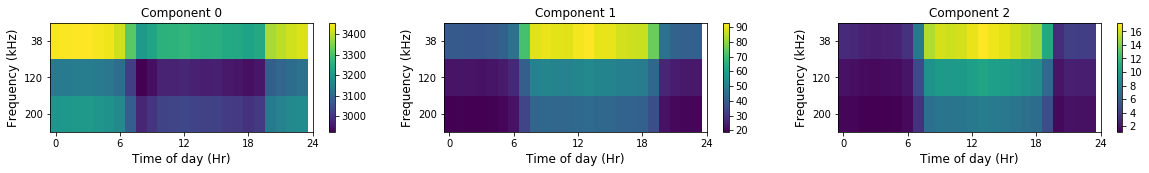

In [73]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[2][:,fac].reshape(3,24),aspect='auto')
    plt.xticks(np.arange(0,25,6), np.arange(0,25,6))
    plt.xlabel('Time of day (Hr)', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

## Checking non-negative parafac results

In [74]:
sonar_tensor.shape

(3, 62, 37, 24)

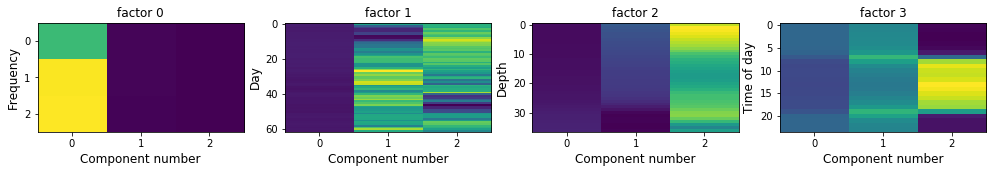

In [75]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_nonneg_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

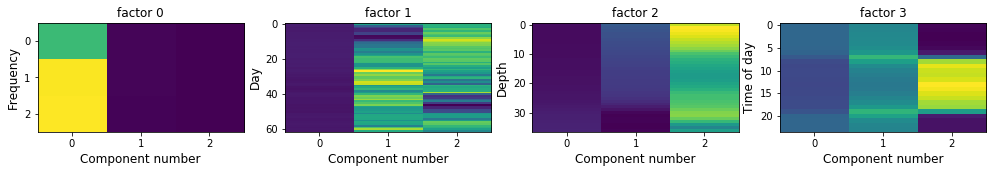

In [76]:
fig,ax = plt.subplots(1,4,figsize=(17,2))
for i in range(4):
    ax[i].imshow(factors_kruskal_nonneg_3[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Frequency',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==2:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(kruskal_rank))

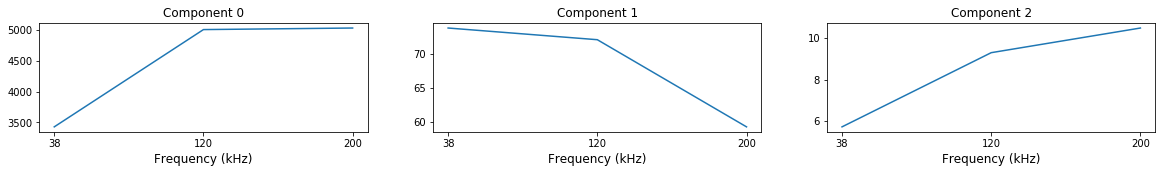

In [78]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[0][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels([38,120,200])
    ax[i].set_xlabel('Frequency (kHz)', fontsize=12)
plt.show()

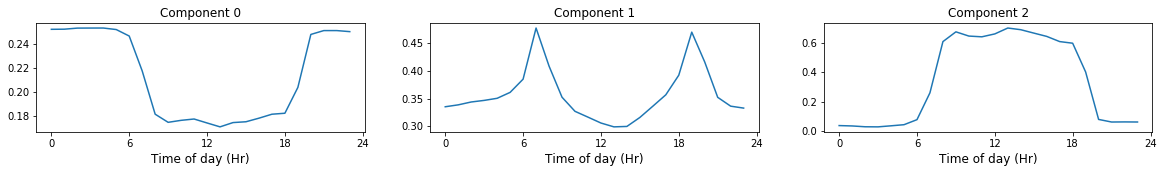

In [79]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[3][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(0,25,6))
    ax[i].set_xticklabels(np.arange(0,25,6))
    ax[i].set_xlabel('Time of day (Hr)', fontsize=12)
plt.show()

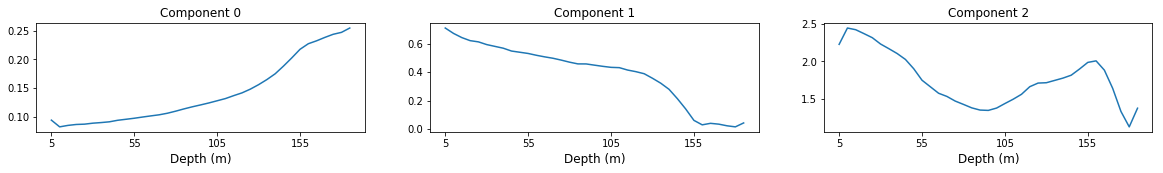

In [80]:
fig,ax = plt.subplots(1,3,figsize=(20,2))
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[2][:,i],label=i)
    ax[i].set_xticks(np.arange(0,37,10))
    ax[i].set_xticklabels((np.arange(0,37,10)+1)*depth_bin_size)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Depth (m)',fontsize=12)
plt.show()

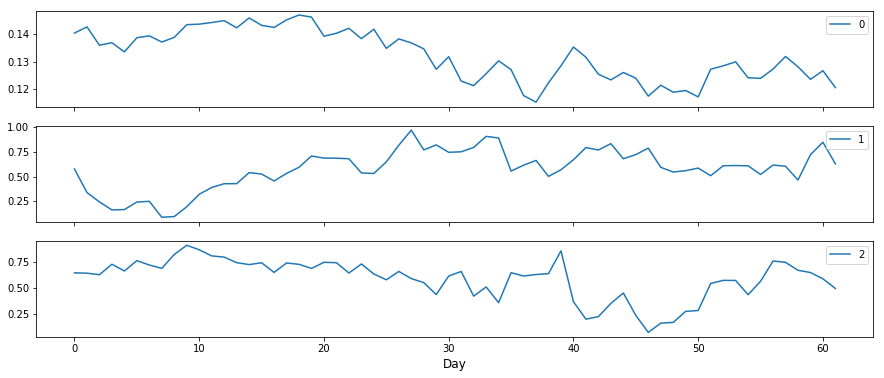

In [81]:
fig,ax = plt.subplots(3,1,figsize=(15,6),sharex=True)
for i in range(3):
    ax[i].plot(factors_kruskal_nonneg_3[1][:,i],label=i)
    ax[i].legend(loc='upper right')
ax[i].set_xlabel('Day',fontsize=12)
plt.show()

### Combine pairs of factors

In [208]:
import itertools

In [209]:
# Khatri-kao product to combine the factors
kr_patterns = []
kr_combs = []
for x,y in itertools.combinations(range(4),2):
    kr_patterns.append((x,y))
    kr_combs.append(khatri_rao((factors_kruskal_nonneg_3[x],factors_kruskal_nonneg_3[y])))

In [210]:
kr_patterns

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [211]:
[x.shape for x in kr_combs]

[(186, 3), (111, 3), (108, 3), (2294, 3), (2232, 3), (1332, 3)]

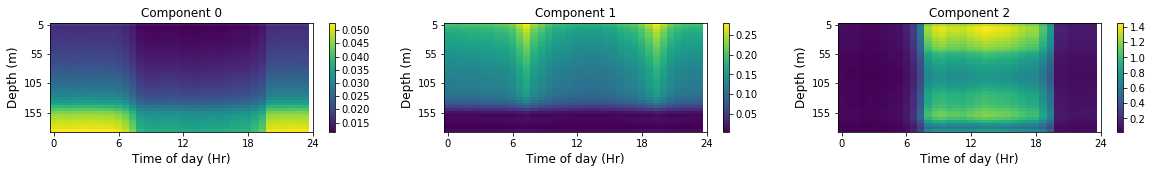

In [218]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[-1][:,fac].reshape(37,36),aspect='auto')
    plt.xticks(np.arange(0,37,9), np.arange(0,25,6))
    plt.xlabel('Time of day (Hr)', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

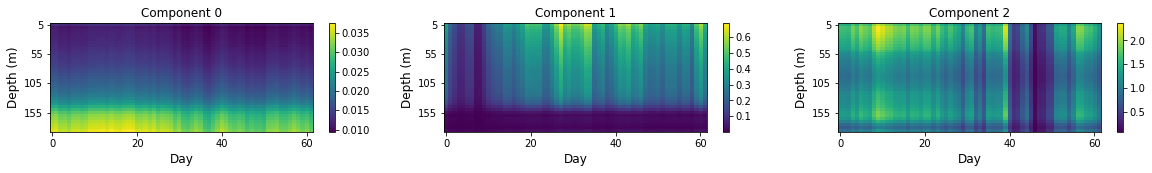

In [231]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kr_combs[3][:,fac].reshape(62,37).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

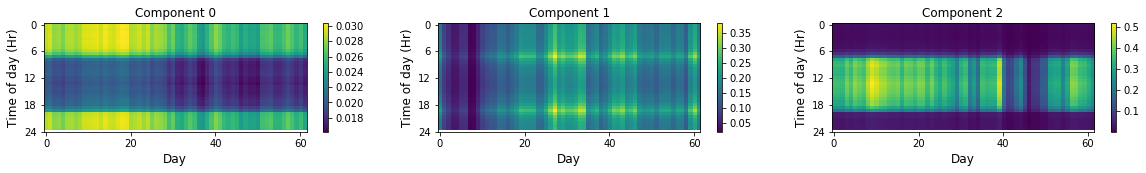

In [224]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kr_combs[-2][:,fac].reshape(62,36).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.yticks(np.arange(0,37,9), np.arange(0,25,6))
    plt.ylabel('Time of day (Hr)', fontsize=12)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.colorbar()

In [232]:
kr_patterns

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [234]:
[x.shape for x in kr_combs]

[(186, 3), (111, 3), (108, 3), (2294, 3), (2232, 3), (1332, 3)]

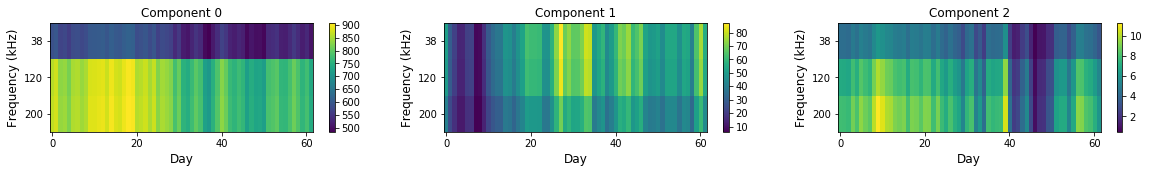

In [239]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[0][:,fac].reshape(3,62),aspect='auto')
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

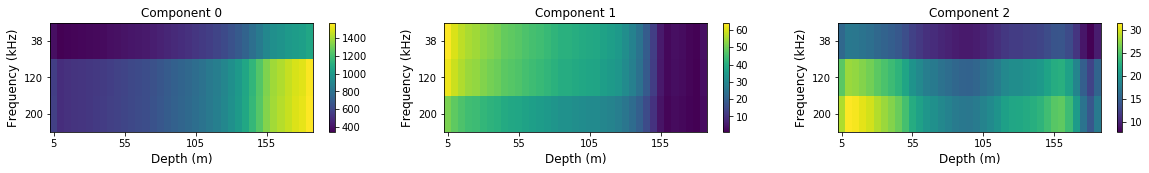

In [242]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[1][:,fac].reshape(3,37),aspect='auto')
    plt.xticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.xlabel('Depth (m)', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

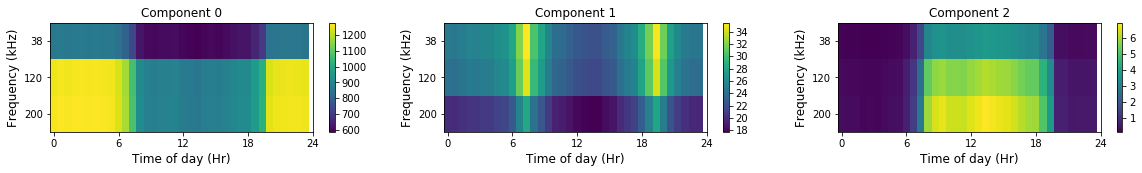

In [244]:
fac_num = 3
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kr_combs[2][:,fac].reshape(3,36),aspect='auto')
    plt.xticks(np.arange(0,37,9), np.arange(0,25,6))
    plt.xlabel('Time of day (Hr)', fontsize=12)
    plt.yticks(np.arange(3),[38,120,200])
    plt.ylabel('Frequency (kHz)', fontsize=12)
    plt.colorbar()

### Try manual reconstruction to make sure I know what's going on

In [82]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [83]:
kr_cube_all = khatri_rao((factors_kruskal_nonneg_3[0],factors_kruskal_nonneg_3[1],
                          factors_kruskal_nonneg_3[2],factors_kruskal_nonneg_3[3]))
kr_cube_all.shape

(165168, 3)

In [84]:
kr_cube_all_0 = kr_cube_all[:,0].reshape(L_sep_reduce.shape)
kr_cube_all_1 = kr_cube_all[:,1].reshape(L_sep_reduce.shape)
kr_cube_all_2 = kr_cube_all[:,2].reshape(L_sep_reduce.shape)

In [85]:
recons_freq_0 = kr_cube_all_0[0,:,:,:]+kr_cube_all_1[0,:,:,:]+kr_cube_all_2[0,:,:,:]

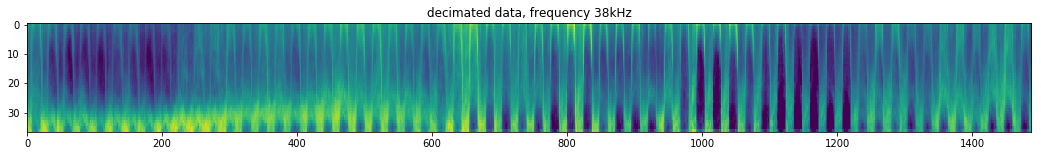

In [86]:
plt.figure(figsize=(18,2))
plt.imshow(tl.unfold(tl.tensor(L_sep_reduce[0,:,:,:].squeeze()),mode=1),
           aspect='auto',vmax=-57, vmin=-85)
plt.title('decimated data, frequency 38kHz')
plt.show()

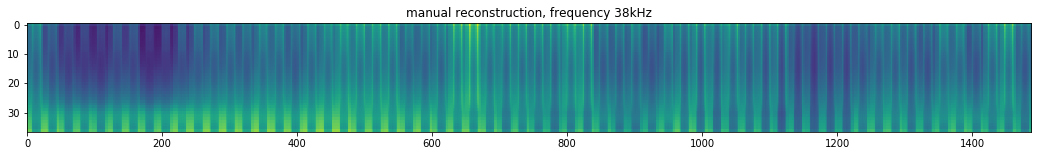

In [87]:
plt.figure(figsize=(18,2))
plt.imshow(tl.unfold(tl.tensor(recons_freq_0)+sonar_tensor.min(),mode=1),
           aspect='auto',vmax=-57, vmin=-85)
plt.title('manual reconstruction, frequency 38kHz')
plt.show()

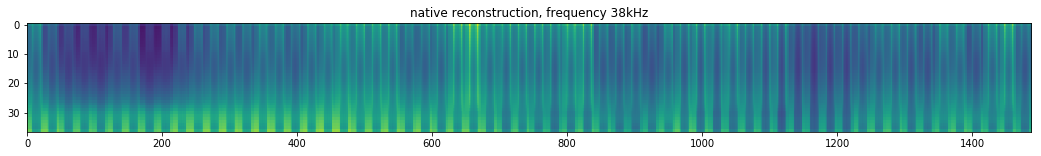

In [88]:
plt.figure(figsize=(18,2))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg_3[0,:,:,:].squeeze()+sonar_tensor.min()),mode=1),
           aspect='auto',vmax=-57, vmin=-85)
plt.title('native reconstruction, frequency 38kHz')
plt.show()

### Check similarity between days and components

In [89]:
k = factors_kruskal_nonneg_3[1].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 3)

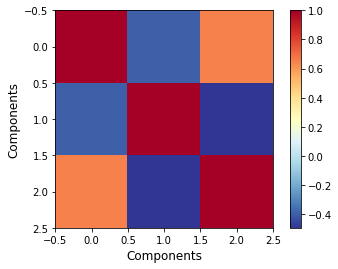

In [90]:
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.xlabel('Components', fontsize=12)
plt.ylabel('Components', fontsize=12)
plt.show()

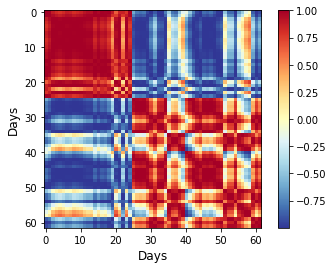

In [91]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.xlabel('Days', fontsize=12)
plt.ylabel('Days', fontsize=12)
plt.show()